In [11]:
# conda activate chronocell

import os
import sys
import numpy as np
import anndata as ad

sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *
from Chronocell.models.two_species_ss import get_Y

2024.10


In [12]:
# Ref: https://www.nature.com/articles/nature10098#Fig2

In [13]:
n = 1000

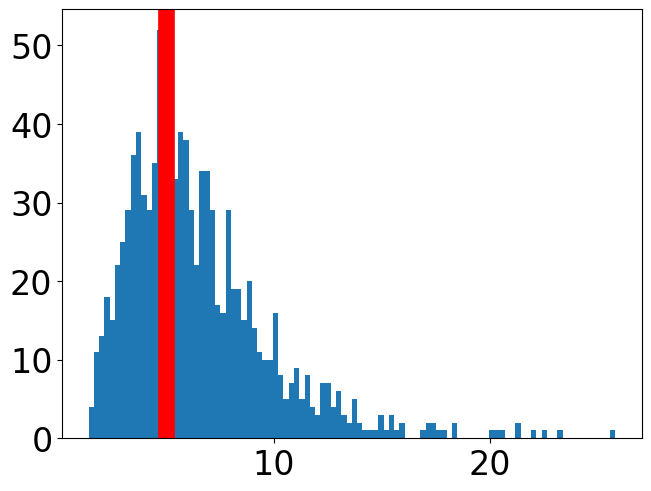

In [14]:
np.random.seed(0)

# Splicing rate
beta_mu = 2
beta_sd = 0.5

beta = np.random.lognormal(beta_mu, beta_sd, size=n)
plt.hist(60*np.log(2)/beta, bins=100);
plt.axvline(x=5, color='r');

/tmp/ipykernel_76816/2488090372.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


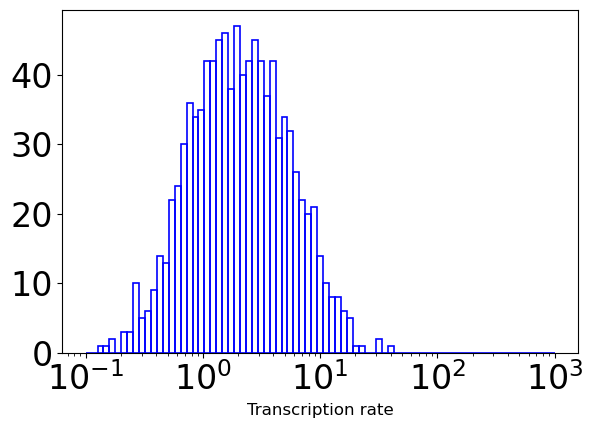

/tmp/ipykernel_76816/2488090372.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


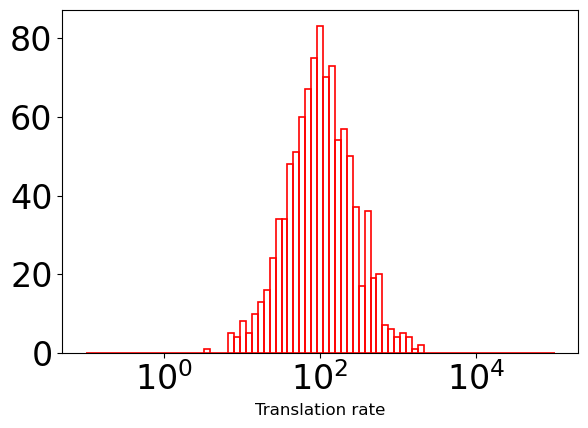

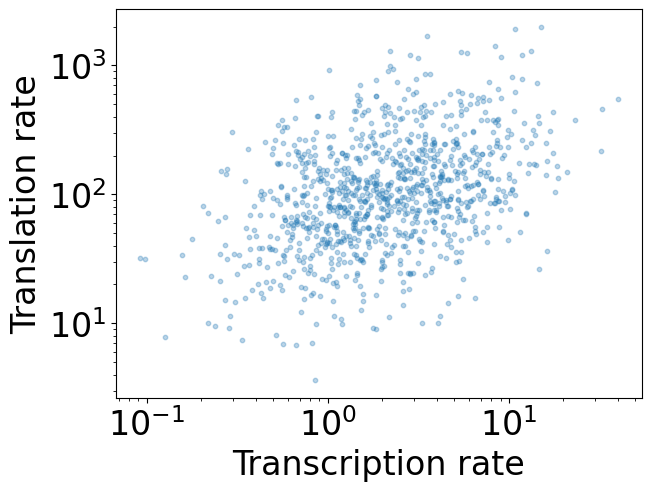

In [15]:
np.random.seed(0)

# Transcription rate
alpha_mu = np.log(2) # 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# Transcription rates and translation rates are assumed to be correlated

rho = .4
cov = [[alpha_sd**2, rho * alpha_sd * transl_rate_sd],
       [rho * alpha_sd * transl_rate_sd, transl_rate_sd**2]]
log_vals = np.random.multivariate_normal(mean=[alpha_mu, transl_rate_mu], cov=cov, size=n)

# Exponentiate to get correlated log-normal variables
alpha = np.exp(log_vals[:, 0])
transl_rate = np.exp(log_vals[:, 1])

# Plot

# Transcription rates
log_bins = np.logspace(-1, 3, 80)
plt.hist(alpha, bins=log_bins, edgecolor='blue', facecolor='none', linewidth=1.2)
plt.xscale('log')
plt.xlabel('Transcription rate', fontsize=12)
plt.tight_layout()
plt.show()

# Translation rates
log_bins = np.logspace(-1, 5, 80)
plt.hist(transl_rate, bins=log_bins, edgecolor='red', facecolor='none', linewidth=1.2)
plt.xscale('log')
plt.xlabel('Translation rate', fontsize=12)
plt.tight_layout()
plt.show()

# Plot alpha vs. beta
plt.scatter(alpha, transl_rate, alpha=0.3, s=10);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Transcription rate')
plt.ylabel('Translation rate')
plt.show()

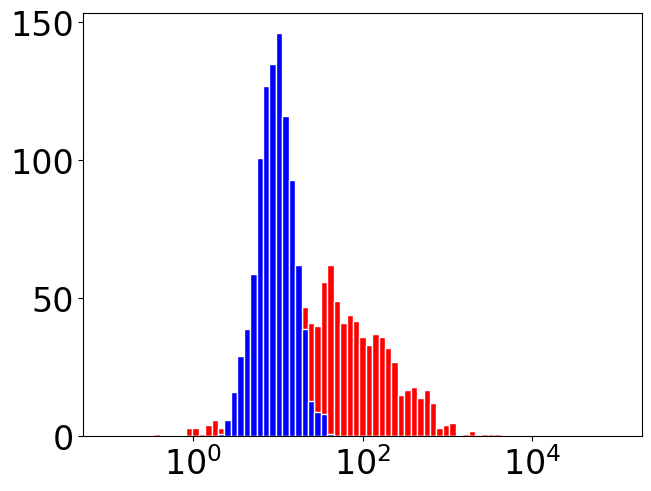

In [16]:
np.random.seed(0)

# mRNA degradation rate
rna_median_half_life = 9
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5
gamma = np.random.lognormal(gamma_mu, gamma_sd, size=n)
rna_half_lives = np.log(2) / gamma

# Protein degradation rate
protein_median_half_life = 46
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5
deg_rate = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=n)
protein_half_lives = np.log(2) / deg_rate

log_bins = np.logspace(-1, 5, 80)
plt.hist(protein_half_lives, bins=log_bins, color='red', edgecolor='white')
plt.hist(rna_half_lives, bins=log_bins, color='blue', edgecolor='white')
# plt.axvline(target_half_life_median, color='black', label='Target median ≈ 50 h')
plt.xscale('log')

In [21]:
# Simulate data

n = 2000 # No. cells per lineage
p = 500 # No. genes
m = 101 # No. time steps

topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 3)
L = len(topo)
n_states = len(set(topo.flatten()))

# # Read depth
# rd_mu = 0.25
# rd_var = 1/64
# a = (1-rd_mu)/rd_var - rd_mu
# b = (1/rd_mu-1)*a
# rd = np.random.beta(a=a, b=b, size=n*L)

In [30]:
np.random.seed(666)

# Simulate RNA counts

# RNA production parameters per gene
theta = np.zeros((p, n_states + 2))
theta[:,:n_states] = np.random.lognormal(alpha_mu, alpha_sd, size=(p, n_states))
theta[:,-2] = np.random.lognormal(beta_mu, beta_sd, size=p) # Generate splicing rates per gene
theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd, size=p) # Generate degradation rates per gene
theta[:,0] /= theta[:,-2] # Normalize state 0 transcription rate by splicing rate 

true_t = []
true_l = []

Y = np.zeros((n*L, p, 2))
for l in range(L):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
    t = np.sort(np.random.uniform(tau[0], tau[-1], size=n)) # EACH TIME POINT IS A CELL
    Y[l*n:(l+1)*n] = get_Y(theta_l, t, tau) # Cells x genes x RNA species
    true_t = np.append(true_t, t)
    true_l = np.append(true_l, np.full(len(t), l))

# theta[:,:n_states] #*= rd_mu 

# Z = rd[:,None,None]*Y
# X = np.random.poisson(Z)
X = np.random.poisson(Y)

# Protein production parameters per gene

phi = np.zeros((p, 2))
phi[:,0] = np.random.lognormal(transl_rate_mu, transl_rate_sd, size=p) # Translation rate per gene
phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=p) # Degradation rate per gene

In [31]:
# phi[:,-1] = np.full(phi[:,-1].shape, phi[:,-1][0]) # Make degradation rate constant

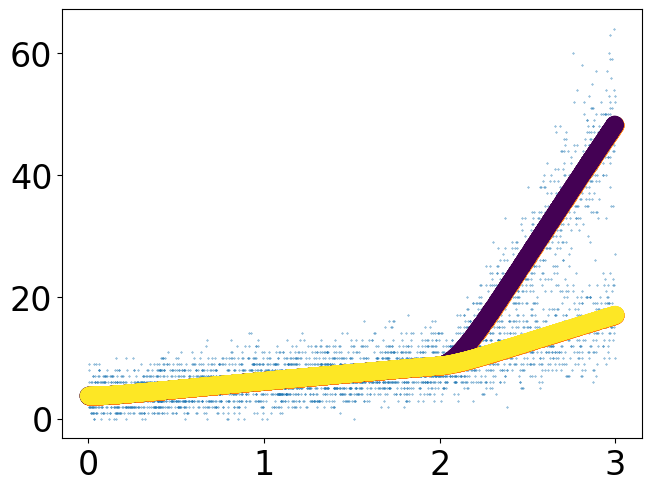

In [34]:
idx = 50
plt.scatter(true_t, X[:, idx, 1], s=.1)
plt.scatter(true_t, Y[:, idx, 1])
plt.scatter(true_t, Y[:, idx, 1], c=true_l)

In [ ]:
# Simulate protein counts

# Inputs

# topo = np.array([[0, 1, 2], [0, 1, 3]])
# tau = (0, 2, 3)
# true_t
# phi
# L = len(topo)
# K = len(tau)-1 # No. states per lineage

y0 = Y[0, :, 1] # Steady-state spliced RNA levels (RNA levels at state 0 at t0
p0 = phi[:,0] * y0

# Protein production paramters:
transl_rate = phi[:,0].T
deg_rate = phi[:,-1].reshape((1, -1))

P = np.zeros((n*L, p))

for l in range(L):
    
    t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
    y_l = Y[l*n:(l+1)*n, :, 1] # Counts from cells in lineage l

    t_diff = t_l - t_l.T 
    # t_diff: rows = target time, columns = past times, e.g. t_diff[m, i] = time difference between t_m and t_i 
    
    t_diff[t_diff < 0] = 0 
    # Time contributions can't be negative
    
    decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) 
    # E.g. decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i (for gene p)

    p_l = p0 * np.exp(-deg_rate * t_l) 
    # Pre-existing protein that has not yet degraded

    protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up to each time point
    p_l += transl_rate * protein_contrib # Newly synthesized protein

    P[l*n:(l+1)*n] = p_l
    
# P1 = np.random.poisson(P)

In [ ]:
import pandas as pd

data = pd.DataFrame(columns=['Cor', 'Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate', 'RNA_half_life', 'Protein_half_life'])

# for l in range(L):
l = 1
theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)

for i in range(p):
    cor = np.corrcoef(Y[l*n:(l+1)*n, i, 1], P[l*n:(l+1)*n, i])[0, 1] # Correlation between RNA and protein abundance for gene i
    alpha_mean = np.mean(theta_l[i, 1:(K+1)]) # Mean transcription rate
    beta = theta_l[i, -2] # Splicing rate 
    gamma = theta_l[i, -1] # RNA degradation rate
    transl_rate = phi[i, 0] # Translation rate
    deg_rate = phi[i, -1] # Protein degradation rate
    r_half = np.log(2) / gamma
    p_half = np.log(2) / deg_rate
    
    data.loc[len(data)] = [cor, alpha_mean, beta, gamma, transl_rate, deg_rate, r_half, p_half]

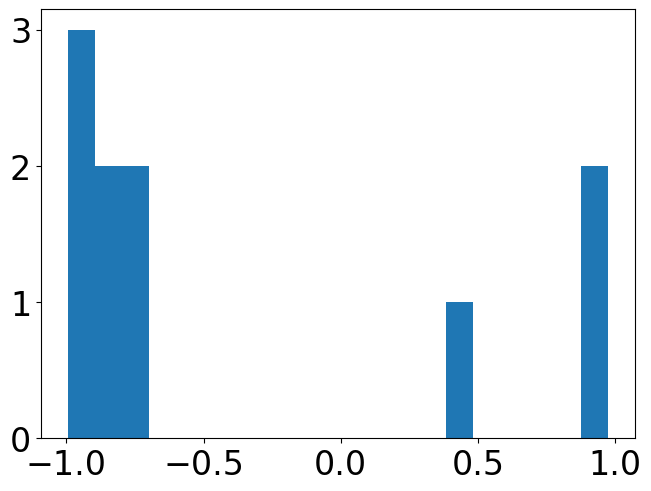

In [108]:
# Correlation between RNA and protein abundance per gene
plt.hist(data['Cor'], bins=20);

In [ ]:
data

,Cor,Alpha,Beta,Gamma,Translation_rate,Degradation_rate,RNA_half_life,Protein_half_life
0,-0.779118,10.893784,4.374199,0.049219,583.603919,0.018703,14.082852,37.061402
1,0.970562,1.235875,3.632754,0.093454,149.205924,0.018703,7.416990,37.061402
2,-0.994025,5.789092,3.148307,0.059657,266.109578,0.018703,11.618831,37.061402
3,-0.975026,2.525475,19.597220,0.042679,940.172515,0.018703,16.241029,37.061402
4,0.429668,1.240186,5.726897,0.075939,647.247125,0.018703,9.127718,37.061402
5,-0.811476,2.398567,5.935569,0.095410,37.633413,0.018703,7.264930,37.061402
6,0.973559,1.062840,3.949553,0.079621,258.593829,0.018703,8.705595,37.061402
7,-0.884723,5.806047,10.899808,0.089591,85.954061,0.018703,7.736804,37.061402
8,-0.763767,1.307193,3.297126,0.056084,90.192956,0.018703,12.359013,37.061402
9,-0.899801,4.067142,6.643440,0.064241,150.771989,0.018703,10.789734,37.061402


In [ ]:
np.corrcoef(data['Cor'], data[''])

array([[ 1.        , -0.50354619],
       [-0.50354619,  1.        ]])

In [123]:
np.corrcoef(data['Cor'], data['Beta'])

array([[ 1.        , -0.36462486],
       [-0.36462486,  1.        ]])

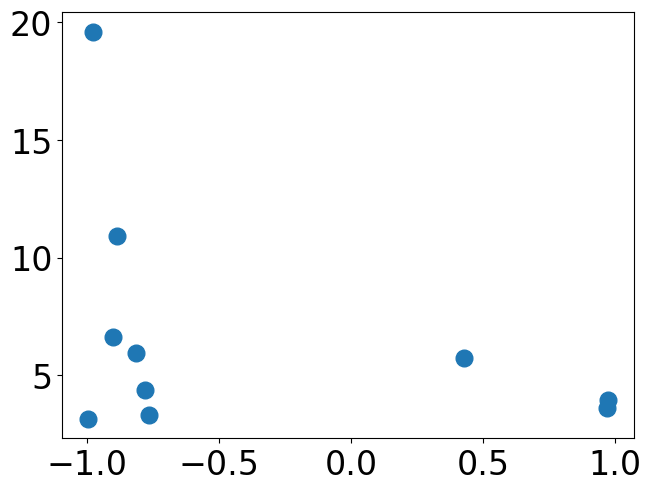

In [122]:
plt.scatter(data['Cor'], data['Beta']);

Cor                  -0.811476
Alpha                 2.398567
Beta                  5.935569
Gamma                 0.095410
Translation_rate     37.633413
Degradation_rate      0.018703
RNA_half_life         7.264930
Protein_half_life    37.061402
Name: 5, dtype: float64
5


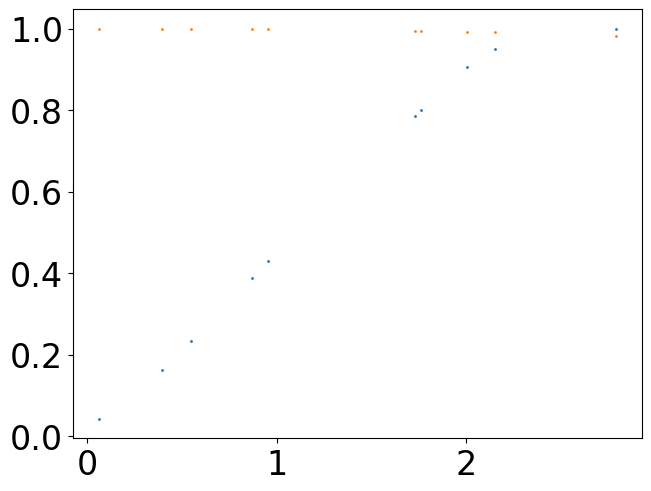

In [109]:
l = 1

cor = 0
idx = 3

i = data.loc[data['Cor'] < 0].index[idx]
print(data.iloc[i])
print(i)
y_i = Y[l*n:(l+1)*n, i, 1]/max(Y[l*n:(l+1)*n, i, 1])
p_i = P[l*n:(l+1)*n, i]/max(P[l*n:(l+1)*n, i])
plt.scatter(true_t[true_l == l], y_i, s=1)
plt.scatter(true_t[true_l == l], p_i, s=1)

Cor                    0.984683
Alpha                  0.795071
Beta                   1.555150
Gamma                  0.059243
Translation_rate     136.761412
Degradation_rate       0.023081
RNA_half_life         11.700079
Protein_half_life     30.030751
Name: 18, dtype: float64
18


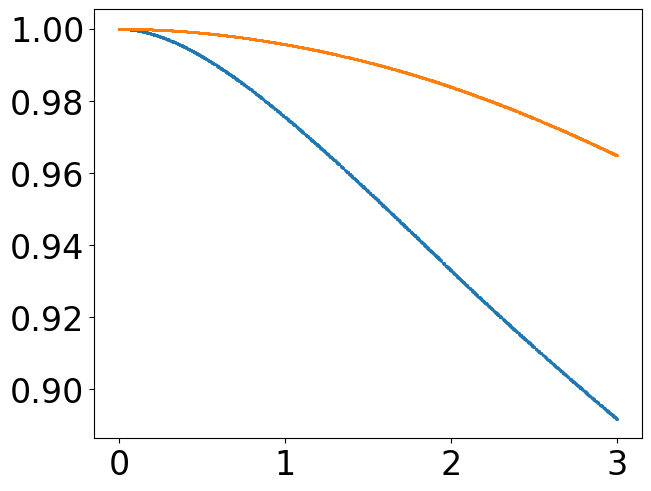

In [161]:
idx = 2
cor = .8

i = data.loc[data['Cor'] > cor].index[idx]
print(data.iloc[i])
print(i)
y_i = Y[l*n:(l+1)*n, i, 1]/max(Y[l*n:(l+1)*n, i, 1])
p_i = P[l*n:(l+1)*n, i]/max(P[l*n:(l+1)*n, i])
plt.scatter(true_t[true_l == l], y_i, s=1)
plt.scatter(true_t[true_l == l], p_i, s=1)


In [ ]:
cor = .9
print(np.corrcoef(data.loc[data['Cor'] > cor, 'Protein_half_life'], data.loc[data['Cor'] > cor, 'RNA_half_life']))
np.corrcoef(data.loc[data['Cor'] > cor, 'Gamma'], data.loc[data['Cor'] > cor, 'Degradation_rate'])

[[ 1.         -0.80323357]
 [-0.80323357  1.        ]]


array([[ 1.        , -0.72092924],
       [-0.72092924,  1.        ]])

In [154]:
cor = -0.4
print(np.corrcoef(data.loc[data['Cor'] < cor, 'Protein_half_life'], data.loc[data['Cor'] < cor, 'RNA_half_life']))
np.corrcoef(data.loc[data['Cor'] < cor, 'Gamma'], data.loc[data['Cor'] < cor, 'Degradation_rate'])

[[ 1.         -0.10349666]
 [-0.10349666  1.        ]]


array([[ 1.        , -0.05073598],
       [-0.05073598,  1.        ]])

[[ 1.         -0.37802116]
 [-0.37802116  1.        ]]


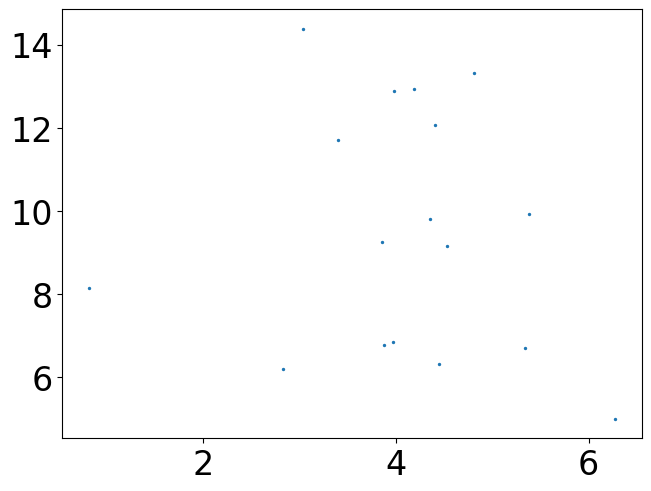

In [157]:
cor = .8

print(np.corrcoef(data.loc[data['Cor'] > cor, 'Protein_half_life'], data.loc[data['Cor'] > cor, 'RNA_half_life']))
plt.scatter(np.log(data.loc[data['Cor'] > cor, 'Protein_half_life']), data.loc[data['Cor'] > cor, 'RNA_half_life'], s=2)

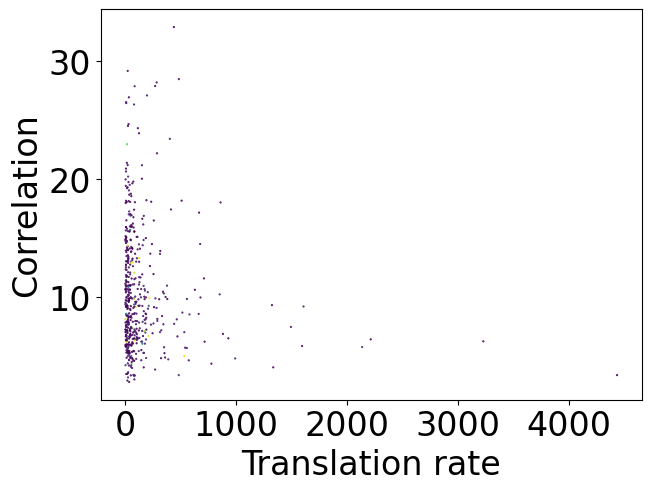

In [153]:
# Translation / protein degradation rate

plt.scatter(data['Protein_half_life'], data['RNA_half_life'], c=data['Cor'], s=0.3);
plt.xlabel("Translation rate");
plt.ylabel("Correlation");

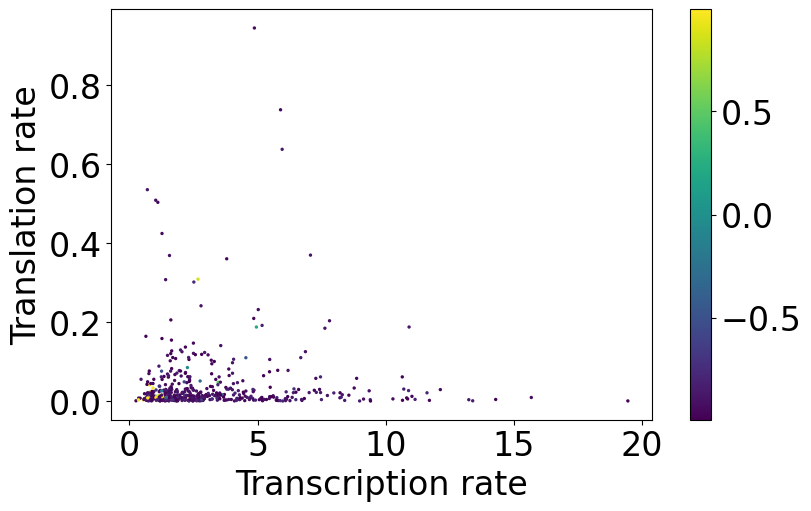

In [145]:
plt.figure(figsize=(8, 5))
plot = plt.scatter(data['Alpha'], data['Degradation_rate'], c=data['Cor'], s=2);
plt.xlabel('Transcription rate');
plt.ylabel('Translation rate');
cbar = plt.colorbar(plot);
plt.show();

/tmp/ipykernel_38798/2643105571.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1, group2], labels=['Cor > 0.5', 'Cor < 0.1'])


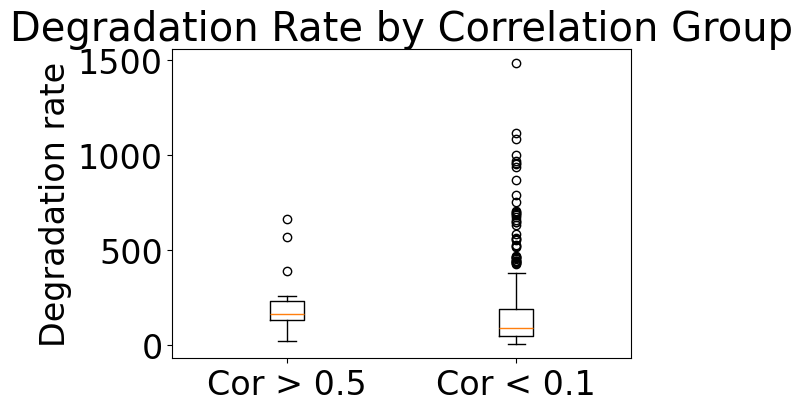

In [149]:
# Prepare the two datasets
group1 = data.loc[data['Cor'] > 0.8, 'Translation_rate']
group2 = data.loc[data['Cor'] < -0.3, 'Translation_rate']
# group1 = data.loc[data['Cor'] > 0.5, 'Translation_rate']
# group2 = data.loc[data['Cor'] < 0, 'Translation_rate']
# group1 = data.loc[data['Cor'] > 0.5, 'Alpha']
# group2 = data.loc[data['Cor'] < 0, 'Alpha']

# Plot
plt.figure(figsize=(6, 4))
plt.boxplot([group1, group2], labels=['Cor > 0.5', 'Cor < 0.1'])

plt.ylabel('Degradation rate')
plt.title('Degradation Rate by Correlation Group')
plt.show()


In [233]:
from sklearn.linear_model import LinearRegression

# Combine all predictors into one 2D array
X = data[['Alpha', 'Beta', 'Gamma', 'Translation_rate', 'Degradation_rate']].values
y = data['Cor'].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Output coefficients and R²
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R² score: {model.score(X, y)}")


Coefficients: [-1.35967951e-01 -9.26656252e-03 -1.16933451e+00  3.05753122e-04
 -5.48891717e-01]
Intercept: 0.5445429417253411
R² score: 0.17505012255045493
